# Collecting Data Final Individual Project - 

# Lyrics Scraping and Sentiment Analysis

### This project contains two parts:

   #### a. scraping lyrics data;

   #### b. lyrics sentiment analysis of two chosen albums from two different singers.
   
   
 
#### The data source of this project is the website: https://www.azlyrics.com/, which contains a large number of lyrics for songs by various artists.

In [10]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Create a function to get all urls of the songs on the chosen album (taking album: "Taylor Swift" (2006) as an example).

By checking the page, we can see that the album id we want to capture is 5765, and the next album id is 6432, so we can use ”find” and “next_siblings()” to capture the content in between the two tags named "id", and use it to capture links to songs from the album 'Taylor Swift'.

In [2]:
def song_urls (url, album_id_to_scrape, next_album_id):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    tag1 = soup.find('div', {'id':album_id_to_scrape})
    tag2 = soup.find('div', {'id':next_album_id})

    tag_list = []
    urls = []
    for tag in tag1.next_siblings:
        if tag == tag2:
            break
        tag_list.append(tag)

    while '\n' in tag_list:
        tag_list.remove('\n')

    for item in tag_list:
        song_url = 'https://www.azlyrics.com/' + item.find('a')['href']
        urls.append(song_url)
    return urls

### Create a function to scrape lyrics of each song.

In [3]:
def get_lyrics(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    title = soup.find('h1').text.replace('"', '').replace(' lyrics', '')
    artist = soup.find('h2').text.replace(' Lyrics', '')
    text = soup.find('div', attrs = 'col-xs-12 col-lg-8 text-center').text.replace('\\', '').replace('\n', '')
    lyrics_dirty, _, _ = text.partition('Submit Corrections')
    _,body = lyrics_dirty.split('\r', 1)
    lyrics = body.replace('\r', ',')
    
    return title, artist, lyrics

### Scrape lyrics data and integrate in a csv file

In the process of scraping data, too many visits in a short period of time will be flagged by the page and cause the scraping process to fail, so an interval of 5 seconds is added.

In [15]:
def get_csv(urls, outname):
    data = []
    for url in urls:
        data.append(get_lyrics(url))
        time.sleep(5)
    lrc = pd.DataFrame(data, columns = ['Title','Artist', 'Lyrics'])
    lrc.to_csv(outname, encoding = 'utf-8')

### Data Scraping

In [16]:
# Taylor Swift's first album - Taylor Swift (2006)

url = 'https://www.azlyrics.com/t/taylorswift.html'
urls = song_urls (url, '5765','6432')
get_csv(urls, 'Lyrics-TaylorSwift.csv')

In [14]:
# Ed Sheeran's first ablum - Ed Sheeran (2006)

url = 'https://www.azlyrics.com/e/edsheeran.html'
urls = song_urls (url, '16703','16704')
get_csv(urls, 'Lyrics-EdSheeran.csv')

### Check information about the dataset

Use df.head() to see the first few rows of the dataset, and df.info() to see the type and missing values of the dataset.

In [65]:
df_ts = pd.read_csv('Lyrics-TaylorSwift.csv', index_col=0)
df_ts.head()

,Title,Artist,Lyrics
0,Tim McGraw,Taylor Swift,He said the way my blue eyes shinedPut those G...
1,Picture To Burn,Taylor Swift,"State the obvious, I didn't get my perfect fan..."
2,Teardrops On My Guitar,Taylor Swift,Drew looks at meI fake a smile so he won't see...
3,A Place In This World,Taylor Swift,"I don't know what I want, so don't ask me'Caus..."
4,Cold As You,Taylor Swift,You have a way of coming easily to meAnd when ...


In [21]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   14 non-null     object
 1   Artist  14 non-null     object
 2   Lyrics  14 non-null     object
dtypes: object(3)
memory usage: 448.0+ bytes


In [61]:
df_es = pd.read_csv('Lyrics-EdSheeran.csv', index_col=0)
df_es.head()

,Title,Artist,Lyrics
0,Open Your Ears,Ed Sheeran,Canât get you off my mindLook at me and you ...
1,Beyond The Pale,Ed Sheeran,Just lay it all down on meItâs getting harde...
2,In Memory,Ed Sheeran,I write this song in memory ofThe wayward smil...
3,Insomniac's Lullaby,Ed Sheeran,Iâm getting very edgyCos youâre trying to ...
4,Quiet Ballad Of Ed,Ed Sheeran,In shadow there lies hopeCut tension with a kn...


In [23]:
df_es.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   13 non-null     object
 1   Artist  13 non-null     object
 2   Lyrics  13 non-null     object
dtypes: object(3)
memory usage: 416.0+ bytes


### Data Celaning

Data cleaning: Clean the dataset and if there are missing values, consider removing rows or columns with more missing values or filling in the missing values with the mean or mode.

But as we can see from the information above, there are no null values in the two DataFrames. So we just need to clean the text data of the lyrics for the next EDA analysis.

I chose to use the WhitespaceTokenizer here because in practice I found that the simple tokenizer incorrectly split words like "don't" into "do" and "n't".

In [88]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

In [30]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elsiana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/elsiana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/elsiana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/elsiana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [97]:
def preprocess_text(text):
    tokenizer = WhitespaceTokenizer()
    words = tokenizer.tokenize(text)
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text


In [98]:
df_ts['Lyrics_Cleaned'] = df_ts['Lyrics'].apply(preprocess_text)
df_ts

,Title,Artist,Lyrics,Lyrics_Cleaned
0,Tim McGraw,Taylor Swift,He said the way my blue eyes shinedPut those G...,said way blue eye shinedPut Georgia star shame...
1,Picture To Burn,Taylor Swift,"State the obvious, I didn't get my perfect fan...","State obvious, get perfect fantasyI realize lo..."
2,Teardrops On My Guitar,Taylor Swift,Drew looks at meI fake a smile so he won't see...,Drew look meI fake smile seeThat want I'm need...
3,A Place In This World,Taylor Swift,"I don't know what I want, so don't ask me'Caus...","know want, ask me'Cause I'm still trying figur..."
4,Cold As You,Taylor Swift,You have a way of coming easily to meAnd when ...,"way coming easily meAnd take, take best meSo s..."
5,The Outside,Taylor Swift,I didn't know what I would findWhen I went loo...,know would findWhen went looking reasonI know ...
6,Tied Together With A Smile,Taylor Swift,Seems the only one who doesn't see your beauty...,Seems one see beautyIs face mirror looking bac...
7,Stay Beautiful,Taylor Swift,"Cory's eyes are like a jungleHe smiles, it's l...","Cory's eye like jungleHe smiles, like radioHe ..."
8,Should've Said No,Taylor Swift,It's strange to think the songs we used to sin...,"strange think song used singThe smiles, flower..."
9,Mary's Song (Oh My My My),Taylor Swift,"She said, I was seven and you were nineI looke...","said, seven nineI looked like star shinedIn sk..."


In [152]:
df_es['Lyrics_Cleaned'] = df_es['Lyrics'].apply(preprocess_text)
df_es

,Title,Artist,Lyrics,Lyrics_Cleaned,sentiment_score
0,Open Your Ears,Ed Sheeran,Canât get you off my mindLook at me and you ...,Canât get mindLook findTime time seemsIâll...,0.3818
1,Beyond The Pale,Ed Sheeran,Just lay it all down on meItâs getting harde...,lay meItâs getting harder breatheJust want k...,0.7059
2,In Memory,Ed Sheeran,I write this song in memory ofThe wayward smil...,write song memory ofThe wayward smileThe boy f...,0.2960
3,Insomniac's Lullaby,Ed Sheeran,Iâm getting very edgyCos youâre trying to ...,Iâm getting edgyCos youâre trying take meA...,-0.5803
4,Quiet Ballad Of Ed,Ed Sheeran,In shadow there lies hopeCut tension with a kn...,shadow lie hopeCut tension knifeI find hard co...,-0.5106
5,No Luck,Ed Sheeran,Iâm screaming out upon my faceFollowed foots...,Iâm screaming upon faceFollowed footstep cat...,0.8426
6,Stevensong,Ed Sheeran,Stevie was a boyWho turned into a manHe never ...,Stevie boyWho turned manHe never master planBu...,-0.5423
7,Billy Ruskin,Ed Sheeran,Mr Ruskin come and paint my pictureWeâre los...,Mr Ruskin come paint pictureWeâre losing sle...,0.8823
8,Spark,Ed Sheeran,Take me with you I do declareI love you dearly...,Take declareI love dearly thereWhat make share...,0.7041
9,Pause,Ed Sheeran,You know I got to get awayTo find some peace a...,know got get awayTo find peace sanityIâve pl...,0.9072


### Data Analysis/Visualisation

use the artists and lyrics in the dataset for word frequency analysis, count the number of songs by the artist, or use the text analysis tool for lyrics for sentiment analysis.

Here, I analyse the lyrics from the two artists' two albums for sentiment and generate a heat map, hoping to analyse the sentiment tendencies of the two artists' songs from their respective debut albums through such visualisation.

In [104]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [107]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elsiana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

 Firstly, the text is analysed for sentiment first, here using the VADER tool, to get the sentiment score for each song. 
 
 And then, add these scores to the DataFrame. 
 
 Finally the heatmap() function of seaborn was used to draw the heat map.

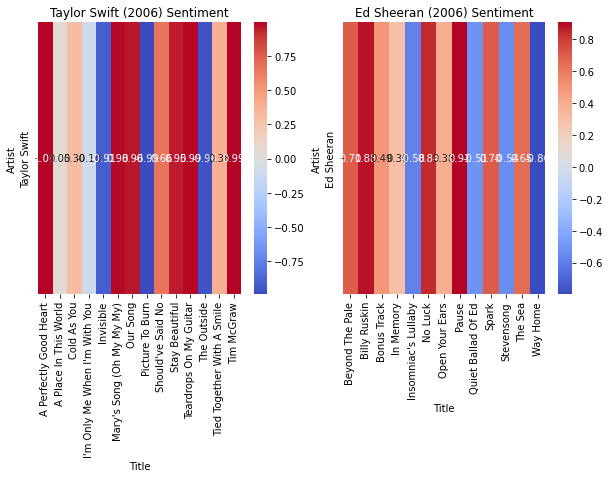

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [151]:
# Taylor Swift (2006) Sentiment
sia = SentimentIntensityAnalyzer()
df_ts['sentiment_score'] = df_ts['Lyrics_Cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Taylor Swift (2006) Sentiment Heat Map
plt.figure(figsize=(10,5))
sns.heatmap(df_ts.pivot_table(values='sentiment_score', 
                           columns='Title', 
                           index='Artist', 
                           aggfunc='mean'),
            annot=True, fmt='.2f', cmap='coolwarm', ax=axs[0])
axs[0].set_title('Taylor Swift (2006) Sentiment')



# Ed Sheeran (2006) Sentiment
sia = SentimentIntensityAnalyzer()
df_es['sentiment_score'] = df_es['Lyrics_Cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Ed Sheeran (2006) Sentiment Heat Map
plt.figure(figsize=(10,5))
sns.heatmap(df_es.pivot_table(values='sentiment_score', 
                           columns='Title', 
                           index='Artist', 
                           aggfunc='mean'),
            annot=True, fmt='.2f', cmap='coolwarm', ax=axs[1])
axs[1].set_title("Ed Sheeran (2006) Sentiment")


plt.subplots_adjust(wspace=0.5)
plt.show()


The two heat maps above show that a very high percentage (6/14) of songs with very positive moods (scores above 0.9) are on Taylor's debut album, while it can also be seen that there are three songs with scores below -0.9. The number of songs with relatively extreme emotions (scores greater than 0.9 in absolute terms) reaches 64% of the album. Thus we can say that Taylor's emotional expression in this album is relatively more overt and more pronounced.

On Ed's debut album, we can see by the colour values of the heat map that there are fewer songs on his album with a very obvious emotional tendency, and he expresses his emotions more subtly through this album.

Ed's songwriting style leans towards modern folk, while Taylor started out as a country singer. The difference between the two genres is one of the reasons why the two albums are distinctly different in terms of lyrical sentiment.

The songs on Taylor's album are mainly about young girls' experiences of love and growing up, and are written with a more personal touch, hence the more emotional lyrics. Ed's songs on this album, on the other hand, are more mature in their lyrical choices, as many of them are based on life lessons.

There are some errors in this study, for example, Taylor Swift's "Tear drops on my guitar" is supposed to be a relatively negative song, but in VADER it is defined as a very positive song.